In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# plt.style.use('ggplot')

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732625 entries, 0 to 1732624
Data columns (total 48 columns):
Status                          category
Sex                             category
Convictions                     category
GangMember                      category
ClassLvl                        float32
Age                             float32
MissionDate                     datetime64[ns]
MissionNumber                   uint32
PULOC                           category
DropLoc                         category
StrikeFromList                  float32
ReasonStruck                    category
R-T                             category
Code                            category
CountryOfCitizenship            category
Juvenile                        bool
MissionWeek                     uint8
MissionQuarter                  uint8
MissionYear                     uint16
MissionMonth                    uint8
Criminality                     category
FamilyUnitFlag                  float32


In [3]:
passenger_cols = ['AlienMasterID', 'Status', 'Sex', 'Convictions', 'GangMember',
       'ClassLvl', 'Age', 'MissionNumber', 'PULOC', 'DropLoc',
       'StrikeFromList', 'ReasonStruck', 'R-T', 'Code', 'CountryOfCitizenship',
       'Juvenile', 'MissionWeek', 'MissionQuarter', 'MissionYear',
       'MissionMonth', 'Criminality', 'FamilyUnitFlag', 'UnaccompaniedFlag',
       'MissionID', 'MissionDate']
airport_cols = ['air_AirportID', 'air_AirportName', 'air_City',
       'st_StateID', 'st_StateAbbr', 'AOR_AORID', 'AOR_AOR', 'AOR_AORName',
       'air_Country', 'air2_AirportID', 'air2_AirportName', 'air2_City',
       'st2_StateID', 'st2_StateAbbr', 'aor2_AORID', 'aor2_AOR',
       'aor2_AORName', 'air2_Country', 'air_LatitudeDecimalDegrees',
       'air_LongitudeDecimalDegrees', 'air2_LatitudeDecimalDegrees',
       'air2_LongitudeDecimalDegrees']
airport1_cols = ['air_AirportID', 'air_AirportName', 'air_City',
       'st_StateID', 'st_StateAbbr', 'AOR_AORID', 'AOR_AOR', 'AOR_AORName',
       'air_Country','air_LatitudeDecimalDegrees', 'air_LongitudeDecimalDegrees']
airport2_cols = ['air2_AirportID', 'air2_AirportName', 'air2_City',
       'st2_StateID', 'st2_StateAbbr', 'aor2_AORID', 'aor2_AOR',
       'aor2_AORName', 'air2_Country', 'air2_LatitudeDecimalDegrees',
       'air2_LongitudeDecimalDegrees']

# Global variables

Here we calculate top-level data on the global scope of the ICE Air dataset.

In [4]:
pre_drop = len(df)
df = df.drop_duplicates()
post_drop = len(df)
assert pre_drop == post_drop

number_of_records = len(df)
print(f'Number of records: {number_of_records}')

unique_AlienMasterID = len(set(df['AlienMasterID']))
assert sum(df['AlienMasterID'].isnull()) == 0
print(f"Unique AlienMasterID values: {unique_AlienMasterID}")

Number of records: 1732625
Unique AlienMasterID values: 1732625


In [5]:
# Span of AlienMaster ID values is greater than number of unique values, so some must be skipped.
df['AlienMasterID'].max() - df['AlienMasterID'].min()

2042246

No missing values in ID fields. IDs repeat.

In [6]:
unique_MissionID = len(set(df['MissionID']))
assert sum(df['MissionID'].isnull()) == 0
print(f"Unique MissionID values: {unique_MissionID}")

unique_MissionNumber = len(set(df['MissionNumber']))
assert sum(df['MissionNumber'].isnull()) == 0
print(f"Unique MissionNumber values: {unique_MissionNumber}")

Unique MissionID values: 14961
Unique MissionNumber values: 14961


One to one relationship of MissionID to MissionNumber. These fields seem to be equivalent. Ordering does not affect calculations.

In [7]:
assert sum(df.groupby(['MissionID'])['MissionNumber'].nunique() > 1) == 0
assert sum(df.groupby(['MissionNumber'])['MissionID'].nunique() > 1) == 0

missions = df.groupby(['MissionDate', 'MissionID', 'MissionNumber', 'PULOC', 'DropLoc'])
missions_alt = df.groupby(['MissionDate', 'MissionNumber', 'MissionID',  'PULOC', 'DropLoc'])
assert len(missions) == len(missions_alt)
del missions_alt
mission_segments = len(missions)
print(f"{mission_segments} unique mission segments, grouped by mission and date.")

41210 unique mission segments, grouped by mission and date.


In [8]:
missions['AlienMasterID'].nunique().sort_values(ascending=False)

MissionDate  MissionID  MissionNumber  PULOC  DropLoc
2012-04-02   3399       121102         KHRL   KAEX       270
2013-07-20   6644       131992         KHRL   KAEX       269
2012-02-29   3213       120921         KHRL   KAEX       267
2012-06-09   3878       121633         KSAT   KELP       262
2017-09-07   39518      171647         KMIA   KABQ       261
2018-11-24   47383      190319         KBRO   KMEM       256
2017-09-02   39491      171604         KABQ   KBRO       248
2016-10-05   37992      170034         KSAN   KSAT       248
2012-05-05   3673       121382         KELP   KHRL       221
2012-12-01   5192       130487         KHRL   KAEX       212
2018-11-24   47383      190319         KBRO   KATL       196
2011-12-07   2692       120443         KELP   KHRL       164
2010-10-18   198        110085         KMDT   KAEX       141
2011-05-10   1321       111205         KMIA   KHRL       140
2011-09-04   2098       111977         KTUS   MMMX       139
2011-09-05   2100       111982 

In [9]:
missions['AlienMasterID'].nunique().mean()

42.04380004853191

In [10]:
df.groupby('MissionID')['AlienMasterID'].nunique().median()

119.0

In [11]:
df.set_index('MissionDate', inplace=True)

In [12]:
temp = df.groupby([pd.Grouper(freq='AS-OCT'), 'MissionID'])['AlienMasterID'].nunique().reset_index()

In [13]:
temp.set_index('MissionDate',inplace=True)

In [14]:
temp.loc['2017']['AlienMasterID'].mean()

117.86285362853629

In [15]:
mission_segments / len(set(df['MissionID']))

2.754495020386338

In [16]:
df.reset_index(inplace=True)

The following is a glimpse of flight segments from the first day in the dataset, showing how flight segments are grouped by `MissionID`/`MissionNumber`. We cannot assume that a unique combination of `PULOC` and `DropLoc` on a given mission represents a specific flight path, only the pickup and dropoff locations of each passenger. Missions can include a combination of both removal (`R`) and transfer (`T`) flights.

If we take ICE's Data Dictionary on its face, each `MissionID`/`MissionNumber` represents a single flight, possibly with multiple pickup and dropoff stops on its itinerary. Reconstructing the exact flight itinerary from this data may not be possible, given that there are no timestamp values below the day level, nor any other explicit indications of consecutive flight segments, other than the original ordering of the records.

In [17]:
missions_rt = df.groupby(['MissionDate', 'MissionID', 'MissionNumber', 'R-T', 'PULOC', 'DropLoc'])
missions_rt['AlienMasterID'].nunique().head(15)

MissionDate  MissionID  MissionNumber  R-T  PULOC  DropLoc
2010-10-01   105        110005         T    KMDT   KAEX       122
             106        110006         R    KHRL   MGGT        67
                                            KSAT   MGGT        37
             107        110007         R    KAEX   MHLM        97
             108        110008         R    KMCI   KHRL        35
                                            KORD   KHRL        63
                                       T    KMCI   KAEX        10
                                            KORD   KAEX        25
             131        110002         R    KBFL   KSAN        13
                                            KOAK   KSAN        43
                                       T    KBFL   KIWA         3
                                                   KSAN         8
                                            KOAK   KIWA        13
                                                   KSAN         5
                 

In [18]:
earliest_record = df['MissionDate'].min()
print(f'Earliest record: {earliest_record.date()}')
latest_record = df['MissionDate'].max()
print(f'Earliest record: {latest_record.date()}')

Earliest record: 2010-10-01
Earliest record: 2018-12-05


In [19]:
number_of_pickup_airports = len(set(df['PULOC'].dropna()))
number_of_dropoff_airports = len(set(df['DropLoc'].dropna()))
total_airports = len(set(df['PULOC']).union(set(df['DropLoc'])))
print(f'Number of pickup airports: {number_of_pickup_airports}')
print(f'Number of dropoff airports: {number_of_dropoff_airports}')
print(f'Total airports: {total_airports}')

Number of pickup airports: 81
Number of dropoff airports: 205
Total airports: 222


In [20]:
number_of_pickup_countries = len(set(df['air_Country'].dropna()))
number_of_dropoff_countries = len(set(df['air2_Country'].dropna()))
total_countries = len(set(df['air_Country']).union(set(df['air2_Country'])))
print(f'Number of pickup countries: {number_of_pickup_countries}')
print(f'Number of dropoff countries: {number_of_dropoff_countries}')
print(f'Total countries: {total_countries}')

Number of pickup countries: 10
Number of dropoff countries: 119
Total countries: 119


The number of unique pickup and dropoff airports represented in the dataset per year can be interpreted as a metric for the expansion of the ICE Air network over time.

In [21]:
droplocs_per_fy = df.resample('AS-OCT', on='MissionDate')['DropLoc']
pulocs_per_fy = df.resample('AS-OCT', on='MissionDate')['PULOC']
drop_countries_per_fy = df.resample('AS-OCT', on='MissionDate')['air2_Country']
pu_countries_per_fy = df.resample('AS-OCT', on='MissionDate')['air_Country']

In [22]:
assert sum(df['DropLoc'].isnull()) == 0
assert sum(df['PULOC'].isnull()) == 0

In [23]:
unique_droplocs = droplocs_per_fy.nunique()
unique_pulocs = pulocs_per_fy.nunique()
unique_countries = drop_countries_per_fy.nunique()
expansion = pd.DataFrame({'Unique Pickup Airports': unique_pulocs,
                          'Unique Dropoff Airports': unique_droplocs,
                          'Unique Destination Countries': unique_countries})
expansion.index = expansion.index.year + 1
expansion.index.name = 'FY'
# expansion.to_csv('../output/iceair-expansion.csv')
expansion

,Unique Pickup Airports,Unique Dropoff Airports,Unique Destination Countries
FY,,,
2011,41,69,35
2012,44,78,42
2013,45,48,16
2014,41,62,20
2015,36,60,32
2016,39,87,54
2017,40,85,49
2018,41,108,69
2019,31,52,23


In [24]:
expansion.loc[2018, 'Unique Pickup Airports']

41

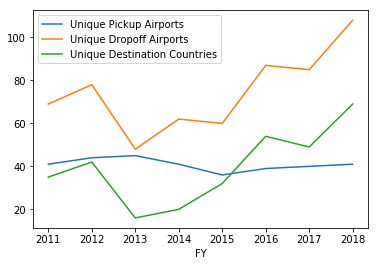

In [25]:
expansion.loc[2011:2018].plot()

In [26]:
usa_pu = set(df.loc[df['air_Country'] == 'USA']['PULOC'])
usa_drop = set(df.loc[df['air2_Country'] == 'USA']['DropLoc'])
foreign_pu = set(df.loc[df['air_Country'] != 'USA']['PULOC'])
foreign_drop = set(df.loc[df['air2_Country'] != 'USA']['DropLoc'])

In [27]:
len(usa_pu.union(usa_drop))

88

In [28]:
foreign_pu

{'EDDF', 'MDSD', 'MGGT', 'MHLM', 'MKJP', 'MMMD', 'MSLP', 'MTPP', 'SEGU'}

In [29]:
len(foreign_pu.union(foreign_drop))

134

# Most common pickup, dropoff airports

By unique `AlienMasterID` values:

In [30]:
df.drop_duplicates('AlienMasterID')['air_AirportName'].value_counts().head(10)

Alexandria International Airport                        239896
Brownsville South Padre Island International Airport    204895
Phoenix-Mesa-Gateway Airport                            196139
El Paso International Airport                           136127
Valley International Airport                            124994
San Antonio International Airport                       107434
Columbus Metropolitan Airport                            80797
Harrisburg International Airport                         76348
Laredo International Airport                             56409
Miami International Airport                              55588
Name: air_AirportName, dtype: int64

In [31]:
df.drop_duplicates('AlienMasterID')['air2_AirportName'].value_counts().head(10)

La Aurora Airport                                       326875
Ramon Villeda Morales International Airport             202955
Alexandria International Airport                        169316
El Salvador International Airport                       157773
Valley International Airport                            148679
Phoenix-Mesa-Gateway Airport                             93892
El Paso International Airport                            87186
Licenciado Benito Juarez International Airport           85584
Brownsville South Padre Island International Airport     66444
San Diego International Airport                          62942
Name: air2_AirportName, dtype: int64

By unique `MissionID` values, an estimate of total number of flights (dropping duplicate date and mission values doesn't change calculation):

In [32]:
count1 = df.drop_duplicates('MissionID')['air_AirportName'].value_counts()
count2 = df.drop_duplicates(['MissionDate', 'MissionID'])['air_AirportName'].value_counts()
assert sum(count1 == count2) == len(count1)
del count1, count2
df.drop_duplicates('MissionID')['air_AirportName'].value_counts().head(10)

Phoenix-Mesa-Gateway Airport                            3183
Alexandria International Airport                        3039
Brownsville South Padre Island International Airport    1550
San Antonio International Airport                       1475
Miami International Airport                             1051
Valley International Airport                             900
El Paso International Airport                            750
Columbus Metropolitan Airport                            369
Laredo International Airport                             279
Harrisburg International Airport                         259
Name: air_AirportName, dtype: int64

In [33]:
count1 = df.drop_duplicates('MissionID')['air2_AirportName'].value_counts()
count2 = df.drop_duplicates(['MissionDate', 'MissionID'])['air2_AirportName'].value_counts()
assert sum(count1 == count2) == len(count1)
del count1, count2
df.drop_duplicates('MissionID')['air2_AirportName'].value_counts().head(10)

La Aurora Airport                                 2923
Ramon Villeda Morales International Airport       1735
El Salvador International Airport                 1420
Alexandria International Airport                   943
Valley International Airport                       927
Licenciado Benito Juarez International Airport     642
San Diego International Airport                    623
El Paso International Airport                      523
Newark Liberty International Airport               403
Harrisburg International Airport                   391
Name: air2_AirportName, dtype: int64

In [34]:
pickup_countries = set(df['air_Country'].dropna())
print(f'Number of pickup countries: {len(pickup_countries)}')
dropoff_countries = set(df['air2_Country'].dropna())
print(f'Number of dropoff countries: {len(dropoff_countries)}')
all_countries = pickup_countries.union(dropoff_countries)
print(f'Total countries in ICE Air network (including US): {len(dropoff_countries)}')

Number of pickup countries: 10
Number of dropoff countries: 119
Total countries in ICE Air network (including US): 119


Top nationalities:

In [35]:
df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                567623
GUATEMALA             421229
HONDURAS              304548
EL SALVADOR           256701
DOMINICAN REPUBLIC     31703
ECUADOR                25686
HAITI                  23308
NICARAGUA              18677
COLOMBIA               14520
JAMAICA                12798
Name: CountryOfCitizenship, dtype: int64

In [36]:
removals = df['R-T'] == 'R'
transfers = df['R-T'] == 'T'

removal_df = df[removals]
transfer_df = df[transfers]

Top nationalities for removals:

In [37]:
removal_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                466108
GUATEMALA             326643
HONDURAS              223786
EL SALVADOR           157538
DOMINICAN REPUBLIC     14878
ECUADOR                 9968
HAITI                   8685
NICARAGUA               8215
COLOMBIA                7372
JAMAICA                 6169
Name: CountryOfCitizenship, dtype: int64

Top nationalities for transfers:

In [38]:
transfer_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                101514
EL SALVADOR            99163
GUATEMALA              94586
HONDURAS               80749
DOMINICAN REPUBLIC     16825
ECUADOR                15717
HAITI                  14623
NICARAGUA              10462
INDIA                   8557
COLOMBIA                7148
Name: CountryOfCitizenship, dtype: int64

In [39]:
removal_df.groupby('CountryOfCitizenship')['MissionID'].nunique()['MAURITANIA']

4

In [40]:
removal_df.groupby('CountryOfCitizenship')['AlienMasterID'].nunique()['MAURITANIA']

12

In [41]:
transfer_df.groupby('CountryOfCitizenship')['AlienMasterID'].nunique()['MAURITANIA']

116

In [42]:
df['R-T'].value_counts(dropna=False)

R             1233912
T              498695
NaN                15
Ineligible          2
No-show             1
Name: R-T, dtype: int64

# Status

In [43]:
status_count = removal_df.drop_duplicates(subset='AlienMasterID')['Status'].str.upper().value_counts(dropna=False)

In [44]:
status = pd.read_csv('../../share/resources/status.csv')

In [45]:
valid_status_codes = list(status['Code'])

In [46]:
status_dict = dict(zip(status['Code'], status['Status']))

In [47]:
problematic = ['2A', '2B', '5C', '5D', '5E', '5F', '8A', '8B', '8D', '8G', '8H', '11']
pending = ['2A', '2B', '8A', '8B', '8D']
benefit = ['5C', '5D']
expedited_admin = ['8F', '8G', '8H', '8I', '11']

In [48]:
problematic_count = 0
valid = removal_df['Status'].str.upper().isin(valid_status_codes)
valid_count = sum(valid)
invalid = ~removal_df['Status'].str.upper().isin(valid_status_codes)
invalid_count = sum(invalid)

print(f'ICE Air - All removals')
print()
print(f'ICE status codes for passengers on direct removal flights.')
print(f'(Statuses which may raise due process concerns starred)')
print()
print(f'{valid_count} valid values.')
print(f'{invalid_count} invalid values.')
print()
for c in valid_status_codes:
    
    try:
        count = status_count[c]
    except KeyError:
        count = 0
    
    if c in problematic:
        problematic_count = problematic_count + count
        print(f'[{c}]: *{count}* ({status_dict[c]})')
    else:
        print(f'[{c}]: {count} ({status_dict[c]})')
print()
print(f'{problematic_count} problematic cases.')

ICE Air - All removals

ICE status codes for passengers on direct removal flights.
(Statuses which may raise due process concerns starred)

839344 valid values.
394568 invalid values.

[1A]: 55104 (Voluntary Departure – Un-Expired and Un-Extended Voluntary Departure.)
[1B]: 284 (Voluntary Departure - Extended Departure Period)
[1C]: 8 (Exipred Voluntary Departure Period - Referred to Investigation)
[2A]: *2223* (Deportable – Under Adjudication by IJ)
[2B]: *96* (Deportable – Under Adjudication by BIA)
[3]: 20572 (Deportable – Administratively Final Order)
[5A]: 14 (Referred for Investigation - No Show for Hearing - No Final O...)
[5B]: 797 (Removable – ICE Fugitive)
[5C]: *16* (Relief Granted – Withholding of Deportation/Removal)
[5D]: *86* (Final Order of Deportation/Removal – Deferred Action Granted.)
[5E]: *32* (Relief Granted – Extended Voluntary Departure)
[5F]: *57* (Unable to Obtain Travel Document)
[8A]: *1489* (Excludable/Inadmissible – Hearing Not Commenced)
[8B]: *4080* (Exc

In [49]:
invalid_status = df[~df['Status'].isin(valid_status_codes)]
status_counts = invalid_status['Status'].value_counts()
bad_statuses = list(status_counts[status_counts > 0].index)

In [50]:
status_counts.head(25)

REMOVAL           231309
RM                164378
NO STATUS          50831
NTA                20931
TRANSFER - F/O     19507
TRANSFER - NTA      9795
REINSTATE           6819
ER-TRANSFER         5917
STAGER              4771
NTA - TRANSFER      3036
F/O - TRANSFER      2620
TRANSFER            2174
REINST              1800
TRANSFER-NTA        1468
WD                  1030
FINAL ORDER          909
JUVI                 845
1/15/1900            747
NTA-TRANSFER         680
WA/NTA               666
NTA-TRFD             663
V/R                  635
DEPORT               584
REIN                 569
RE-INSTATE           484
Name: Status, dtype: int64

## Status by FY for removals & transfers

In [51]:
status_fy = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT', on='MissionDate')['Status'].value_counts().unstack()

In [52]:
total = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT', on='MissionDate')['AlienMasterID'].nunique()

In [53]:
status_fy[expedited_admin]

Status,8F,8G,8H,8I,11
MissionDate,,,,,
2010-10-01,9899.0,1.0,NaN,NaN,174.0
2011-10-01,22038.0,NaN,NaN,NaN,92.0
2012-10-01,52132.0,462.0,9.0,5.0,2298.0
2013-10-01,53894.0,2556.0,164.0,33.0,3008.0
2014-10-01,32056.0,4049.0,61.0,80.0,3832.0
2015-10-01,29940.0,10335.0,246.0,128.0,3741.0
2016-10-01,26146.0,13062.0,1264.0,214.0,2913.0
2017-10-01,32839.0,12492.0,349.0,276.0,2652.0
2018-10-01,6290.0,2686.0,38.0,45.0,399.0


In [54]:
status_fy[valid_status_codes].to_csv('../output/valid_status_by_year.csv')

In [55]:
all_others = status_fy[status_fy.columns[~status_fy.columns.isin(valid_status_codes)]].sum(axis=1)
all_others.name = 'all_others'

In [56]:
status_table = pd.concat([status_fy[valid_status_codes], all_others], axis=1).T

In [57]:
status_table

MissionDate,2010-10-01 00:00:00,2011-10-01 00:00:00,2012-10-01 00:00:00,2013-10-01 00:00:00,2014-10-01 00:00:00,2015-10-01 00:00:00,2016-10-01 00:00:00,2017-10-01 00:00:00,2018-10-01 00:00:00
1A,22425.0,22071.0,9738.0,513.0,264.0,36.0,23.0,27.0,7.0
1B,NaN,NaN,112.0,93.0,72.0,1.0,1.0,4.0,1.0
1C,NaN,NaN,3.0,5.0,NaN,NaN,NaN,NaN,NaN
2A,NaN,NaN,994.0,233.0,301.0,106.0,217.0,325.0,47.0
2B,NaN,NaN,15.0,13.0,11.0,15.0,24.0,15.0,3.0
3,1149.0,555.0,1281.0,1737.0,2645.0,3354.0,4033.0,4953.0,865.0
5A,NaN,NaN,2.0,4.0,3.0,NaN,2.0,2.0,1.0
5B,NaN,NaN,68.0,241.0,141.0,65.0,133.0,137.0,12.0
5C,NaN,NaN,1.0,4.0,4.0,1.0,2.0,3.0,1.0
5D,NaN,NaN,16.0,18.0,8.0,4.0,19.0,17.0,4.0


In [58]:
status_table.to_csv('../output/removal_status_by_year.csv')
(status_table/total).to_csv('../output/removal_status_by_year_percent.csv')

# Removal versus transfer rates

We might be interested in whether some groups are disproportionately transferred prior to removal. However, these values will be highly skewed because some groups have very few total removals, and high rate of transfer does not necessarily imply rights violations.

In [59]:
removal_count = df.loc[df['R-T'] == 'R'].drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts()
transfer_count =  df.loc[df['R-T'] == 'T'].drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts()
transfer_rate = (transfer_count / removal_count).sort_values(ascending = False)
valid_comparisons = transfer_rate[transfer_rate != np.inf]

In [60]:
country = "GUATEMALA"

In [61]:
print(f'{country}: {round(valid_comparisons[country], 3)} transfers per removal ({transfer_count[country]}/{removal_count[country]})')

GUATEMALA: 0.29 transfers per removal (94586/326643)


# Most common, most passenger flight paths

We can rank flight paths by number of missions or unique passengers, perhaps for calculating costs of a common flight path.

In [62]:
most_common_flight_paths = df.groupby(['PULOC','DropLoc'])['MissionID'].nunique()
most_common_flight_path = most_common_flight_paths.idxmax()
most_common_flight_path_count =  most_common_flight_paths[most_common_flight_path]
most_passenger_flight_paths = df.groupby(['PULOC','DropLoc'])['AlienMasterID'].nunique()
most_passenger_flight_path = most_passenger_flight_paths.idxmax()
most_passenger_flight_path_count = most_passenger_flight_paths[most_passenger_flight_path]

In [63]:
print(f'Most frequent flight path: {most_common_flight_path}, {most_common_flight_path_count} missions')
print(f'Flight path with most passengers: {most_passenger_flight_path}, {most_passenger_flight_path_count} passengers')

Most frequent flight path: ('KOAK', 'KSAN'), 919 missions
Flight path with most passengers: ('KBRO', 'MGGT'), 91714 passengers


In [64]:
most_passenger_flight_path_trips = df.groupby(['PULOC','DropLoc'])['MissionNumber'].nunique()[most_passenger_flight_path]

In [65]:
cost_per_hour = 7785

In [66]:
kbro_to_mggt_duration_hrs = 5

In [67]:
most_passenger_flight_path_trips * kbro_to_mggt_duration_hrs * cost_per_hour

35694225

In [68]:
flight_path_rank = most_common_flight_paths.sort_values(ascending=False).reset_index()

In [69]:
flight_path_cross_table = most_common_flight_paths.unstack()
passenger_count_cross_table = most_passenger_flight_paths.unstack()

This is probably not a super interesting way to display this info but...

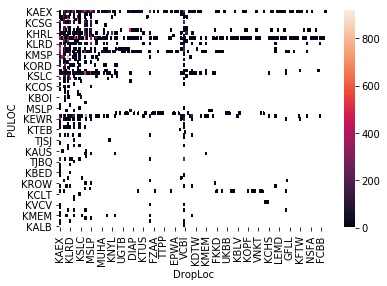

In [70]:
sns.heatmap(flight_path_cross_table)

# Trend charts

Charts for global trends in the ICE Air dataset, starting with simple plot of total removals and transfers per fiscal year (excluding FY19):

In [71]:
removal_df = df.loc[df['R-T'] == 'R']
transfer_df = df.loc[df['R-T'] == 'T']
removal_df.set_index('MissionDate', inplace=True)
transfer_df.set_index('MissionDate', inplace=True)

In [72]:
removal_percent = len(df.loc[df['R-T'] == 'R']) / len(df)
transfer_percent = len(df.loc[df['R-T'] == 'T']) / len(df)

In [73]:
round((len(set(df['MissionID'])) / 1000), 1)

15.0

In [74]:
df.name = 'Passengers'
removal_df.name = 'Removals'
transfer_df.name = 'Transfers'

In [75]:
df.set_index('MissionDate', inplace=True)

In [76]:
total_passengers = df['AlienMasterID'].resample('AS-OCT').nunique().rename('Total passengers', inplace=True)
annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique().rename('Total removals', inplace=True)
annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique().rename('Total transfers', inplace=True)
annual_removal_flights = removal_df['MissionID'].resample('AS-OCT').nunique()
annual_transfer_flights = transfer_df['MissionID'].resample('AS-OCT').nunique()

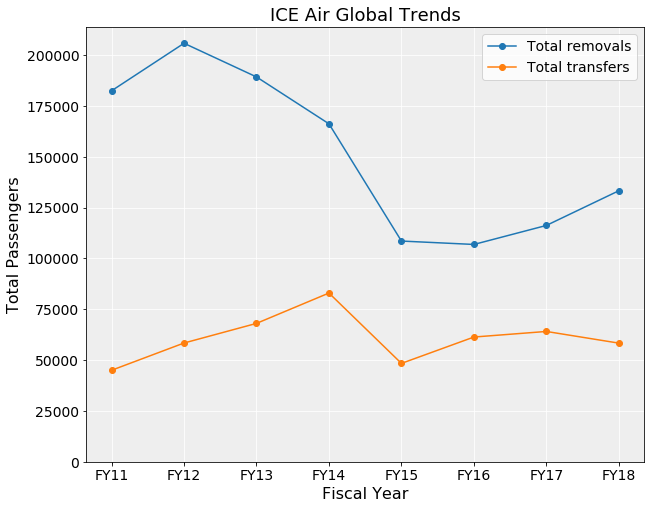

In [77]:
def pickup_dropoff_trend(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(style='o-', legend=True)
    
    ax.set_axisbelow(True)
    ax.set_ylabel('Total Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2010,2019)])
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'ICE Air Global Trends', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/ICE-Air-Global-Trends.png', dpi=100)
    return fig, ax

plot = pickup_dropoff_trend([annual_removals['2010':'2017'], annual_transfers['2010':'2017']]);

In [78]:
r_t_annual = pd.DataFrame({'Removals': annual_removals['2010':'2017'], 'Transfers': annual_transfers['2010':'2017']})
r_t_annual.index = [f'FY{str(x)[2:4]}' for x in r_t_annual.index.year + 1]

In [79]:
r_t_annual.loc['FY12'].sum()

264230

In [80]:
def removal_transfer_bar(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))
    
    ax.set_axisbelow(True)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    plt.legend(fontsize=14)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

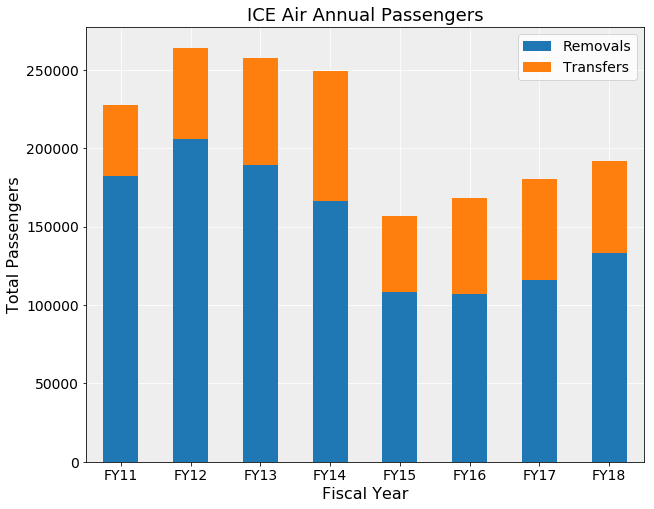

In [81]:
removal_transfer_bar(r_t_annual,
                     title=f'ICE Air Annual Passengers',
                     filename=f'annual_passengers_bar',
                     ylabel=f'Total Passengers',
                     xlabel='Fiscal Year');

In [82]:
r_t_annual['Removals'].idxmin()

'FY16'

In [83]:
r_t_annual

,Removals,Transfers
FY11,182447,45011
FY12,205814,58416
FY13,189259,68065
FY14,166204,82989
FY15,108554,48392
FY16,106882,61352
FY17,116231,64097
FY18,133289,58355


# Charts of nationalities per year

## Top 5 per year

To look at removals or other variables by `CountryOfCitizenship` per fiscal year (excluding FY19), we will want to select most common values and sum the rest, in order to create a clean chart. Method below selects top 5 nationalities per year, and sums the rest as "ALL OTHERS".

This is slightly counterintuitive, for example it creates illusion of no Dominican Republic removals in FY17. Maybe better solution would be to display for each year any nationality that is in top 5 for any given year. Alternatively, we could just plot top 5 values, or include several more over a certain threshold. Or we could plot all values for nationalities which are in the top 5 for any year.

In [84]:
# df.set_index('MissionDate', inplace=True)

In [85]:
# Set DataFrame or subset to chart here. Remember to set name as well.
df_to_analyze = removal_df
df_to_analyze.name = removal_df.name

In [86]:
g = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)
country_of_citizenship_by_year.set_index('FY', inplace=True)
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [87]:
# Selecting only years for which we have full data (FY2011 - FY2018).
country_of_citizenship_by_year = country_of_citizenship_by_year['2010':'2017']

In [88]:
removal_nationality_by_year = country_of_citizenship_by_year.groupby([pd.Grouper(freq='AS-OCT'),'CountryOfCitizenship'])[['AlienMasterID']].sum().dropna(how='all',axis=0).unstack()
# removal_nationality_by_year.to_csv(f'../output/removal_nationality_by_year.csv')

In [89]:
removal_nationality_by_year

AlienMasterID                                            \
CountryOfCitizenship        BRAZIL CAMEROON CAPE VERDE CHINA COLOMBIA   CUBA   
FY                                                                             
2010-10-01                     1.0      2.0        4.0   6.0   1059.0   31.0   
2011-10-01                     NaN      1.0        NaN   NaN   1020.0   34.0   
2012-10-01                     NaN      NaN        NaN   NaN    943.0   16.0   
2013-10-01                     NaN      7.0        NaN   NaN    865.0    6.0   
2014-10-01                     NaN      9.0        NaN  16.0    847.0   16.0   
2015-10-01                     NaN      3.0        NaN   NaN    847.0   25.0   
2016-10-01                     NaN      5.0        NaN  47.0    795.0   53.0   
2017-10-01                     8.0     13.0        7.0  93.0    866.0  255.0   

                                                                     ...    \
CountryOfCitizenship DOMINICAN REPUBLIC ECUADOR EL SALVADOR  GHANA   ...     
FY                                                                   ...     
2010-10-01                       2343.0  1436.0     15817.0   17.0   ...     
2011-10-01                       2281.0  1593.0     18107.0   14.0   ...     
2012-10-01                       1849.0  1318.0     20178.0    NaN   ...     
2013-10-01                       1747.0  1377.0     26507.0    NaN   ...     
2014-10-01                       1552.0  1153.0     21378.0    NaN   ...     
2015-10-01                       1556.0   980.0     20089.0   17.0   ...     
2016-10-01                       1696.0   929.0     17970.0  172.0   ...     
2017-10-01                       1520.0  1036.0     14516.0  130.0   ...     

                                                                              \
CountryOfCitizenship MOROCCO SOUTH AFRICA ST. LUCIA BURKINA FASO SOUTH SUDAN   
FY                                                                             
2010-10-01               NaN          NaN       NaN          NaN         NaN   
2011-10-01               NaN          NaN       NaN          NaN         NaN   
2012-10-01               NaN          NaN       NaN          NaN         NaN   
2013-10-01               NaN          NaN       NaN          NaN         NaN   
2014-10-01               NaN          NaN       NaN          NaN         NaN   
2015-10-01               NaN          NaN       NaN          NaN         NaN   
2016-10-01               NaN          NaN       NaN          NaN         NaN   
2017-10-01               1.0          1.0       2.0          5.0        61.0   

                                                                         \
CountryOfCitizenship ANTIGUA & BARBUDA BURMA SAMOA UNITED ARAB EMIRATES   
FY                                                                        
2010-10-01                         NaN   NaN   NaN                  NaN   
2011-10-01                         NaN   NaN   NaN                  NaN   
2012-10-01                         NaN   NaN   NaN                  NaN   
2013-10-01                         NaN   NaN   NaN                  NaN   
2014-10-01                         NaN   NaN   NaN                  NaN   
2015-10-01                         NaN   NaN   NaN                  NaN   
2016-10-01                         NaN   NaN   NaN                  NaN   
2017-10-01                         3.0  33.0   6.0                  1.0   

                              
CountryOfCitizenship NAMIBIA  
FY                            
2010-10-01               NaN  
2011-10-01               NaN  
2012-10-01               NaN  
2013-10-01               NaN  
2014-10-01               NaN  
2015-10-01               NaN  
2016-10-01               NaN  
2017-10-01               2.0  

[8 rows x 126 columns]

In [90]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

In [91]:
# Note 0 values in this version of chart. Missing values are included in "ALL OTHERS" category.
top_5_data

CountryOfCitizenship,ALL OTHERS,DOMINICAN REPUBLIC,EL SALVADOR,GUATEMALA,HAITI,HONDURAS,MEXICO
FY11,4965,2343,15817,30472,0,21069,107781
FY12,5449,2281,18107,38399,0,30815,110763
FY13,4867,1849,20178,47955,0,35759,78651
FY14,4712,1747,26507,54135,0,39825,39278
FY15,3951,1552,21378,32599,0,19613,29461
FY16,3881,1556,20089,32963,0,21311,27082
FY17,6306,0,17970,32198,5549,21241,32967
FY18,5973,1520,14516,48765,0,27777,34738


In [92]:
top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]
top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [93]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    ax.set_axisbelow(True)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)
    plt.legend(fontsize=14)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

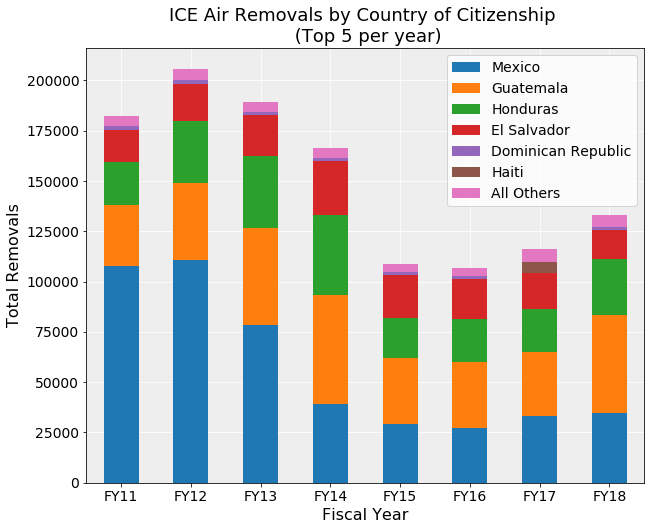

In [94]:
country_of_citizenship_trend(top_5_data,
                             title=f'ICE Air {df_to_analyze.name} by Country of Citizenship \n (Top 5 per year)',
                             filename=f'top5_total_deportation_nationalities_per_year',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

## Top 5 any year

Here's the alternate plot showing all nationalities which break the top 5 in any year. A bit messier, but outliers are still clear (El Salvador in FY14, Haiti in FY17, India in FY18), steady trends possibly clearer (Ecuador, Dominican Republic).

In [95]:
in_top_5 = list()
for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    in_top_5.extend(list(temp_top_5['CountryOfCitizenship']))

In [96]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[temp['CountryOfCitizenship'].isin(list(set(in_top_5)))]
    if len(temp) > 5:
        all_others = temp[~temp['CountryOfCitizenship'].isin(list(set(in_top_5)))]
        all_other_count = sum(all_others['AlienMasterID'])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]
top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [97]:
# Table for this version of chart is much better
top_5_data

Country of Citizenship,Mexico,Guatemala,Honduras,El Salvador,Dominican Republic,Haiti,All Others
FY11,107781,30472,21069,15817,2343,228,4737
FY12,110763,38399,30815,18107,2281,547,4902
FY13,78651,47955,35759,20178,1849,452,4415
FY14,39278,54135,39825,26507,1747,338,4374
FY15,29461,32599,19613,21378,1552,369,3582
FY16,27082,32963,21311,20089,1556,267,3614
FY17,32967,32198,21241,17970,1696,5549,4610
FY18,34738,48765,27777,14516,1520,805,5168


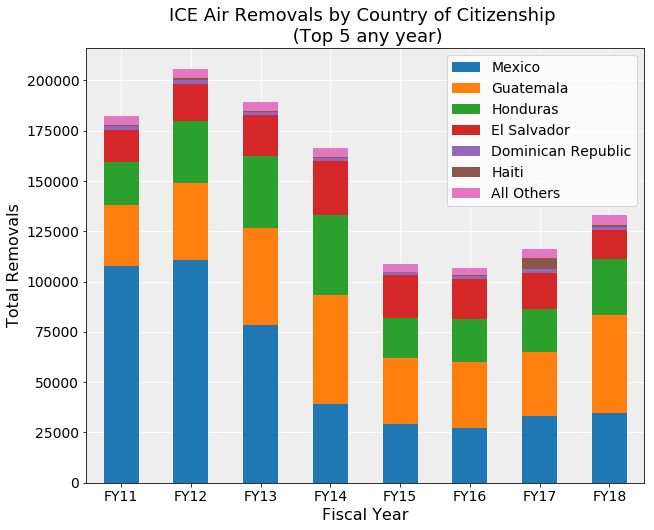

In [98]:
country_of_citizenship_trend(top_5_data,
                             title=f'ICE Air {df_to_analyze.name.title()} by Country of Citizenship \n (Top 5 any year)',
                             filename=f'top5_total_{df_to_analyze.name.lower()}_nationalities_any_year',
                             ylabel=f'Total {df_to_analyze.name.title()}',
                             xlabel='Fiscal Year');

In [99]:
cent_am = ['MEXICO', 'GUATEMALA', 'HONDURAS', 'EL SALVADOR']

cent_am_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_cent_am = temp[temp['CountryOfCitizenship'].isin(list(set(cent_am)))]
    cent_am_count = sum(temp_cent_am['AlienMasterID'])
    if len(temp) > 5:
        all_others = temp[~temp['CountryOfCitizenship'].isin(list(set(cent_am)))]
        all_other_count = sum(all_others['AlienMasterID'])
    else:
        all_other_count = 0
    temp_df = pd.DataFrame([['MEXICO + NORTHERN TRIANGLE', cent_am_count],
                            ['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year, year])
    cent_am_df = cent_am_df.append(temp_df)
    
cent_am_df.sort_index(inplace=True)
cent_am_df.index = [f'FY{str(x)[2:4]}' for x in cent_am_df.index.year + 1]

cent_am_data = pd.pivot_table(data=cent_am_df,
                       index=cent_am_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

cent_am_data = cent_am_data.reindex(cent_am_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(cent_am_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
cent_am_data = cent_am_data[cols]
cent_am_data.columns = cent_am_data.columns.str.title()
cent_am_data.columns.name = 'Country of Citizenship'

In [100]:
(cent_am_data.div(cent_am_data.sum(axis=1), axis=0) * 100).mean()

Country of Citizenship
Mexico + Northern Triangle    94.853306
All Others                     5.146694
dtype: float64

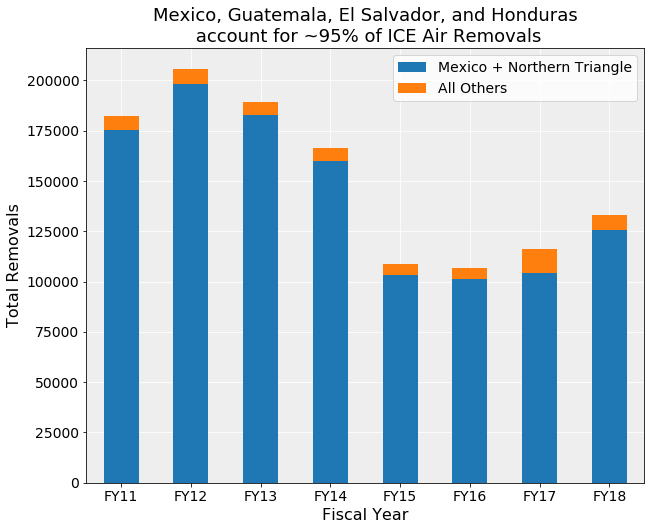

In [101]:
country_of_citizenship_trend(cent_am_data,
                             title=f'Mexico, Guatemala, El Salvador, and Honduras\n \
account for ~95% of ICE Air {df_to_analyze.name.title()}',
                             filename=f'cent_am_removals',
                             ylabel=f'Total {df_to_analyze.name.title()}',
                             xlabel='Fiscal Year');

In [102]:
sum(removal_df['CountryOfCitizenship'].isin(cent_am)) / len(removal_df) * 100

95.15062662491329

# Investigating other global variables

In [103]:
df['Juvenile'].value_counts(dropna=False)

False    1706578
True       26047
Name: Juvenile, dtype: int64

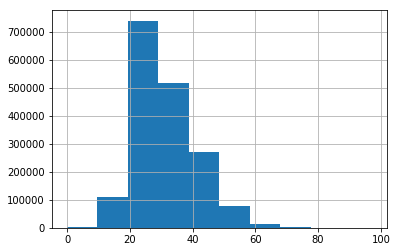

In [104]:
df['Age'].hist(bins=10)

In [105]:
df.groupby(['CountryOfCitizenship', 'R-T'])['Age'].mean()

CountryOfCitizenship            R-T
ALGERIA                         R      35.666668
                                T      36.555557
ARGENTINA                       R      43.214287
                                T      39.827587
ARMENIA                         T      33.634750
BANGLADESH                      R      33.669144
                                T      30.253986
BARBADOS                        R      42.500000
                                T      39.729168
BOLIVIA                         R      34.000000
                                T      35.036083
BOSNIA                          R      31.700001
                                T      31.839506
BRAZIL                          R      38.312500
                                T      33.468433
BRITISH VIRGIN ISLANDS          T      39.571430
BULGARIA                        R      31.000000
                                T      39.063492
CAMBODIA                        R      41.174999
                                T

In [106]:
df.groupby([pd.Grouper(freq='AS-OCT')])['Age'].mean()

MissionDate
2010-10-01    31.539486
2011-10-01    31.316971
2012-10-01    30.838612
2013-10-01    29.555210
2014-10-01    31.360340
2015-10-01    31.364080
2016-10-01    32.182800
2017-10-01    31.831917
2018-10-01    30.838182
Freq: AS-OCT, Name: Age, dtype: float32

In [107]:
df.groupby([pd.Grouper(freq='AS-OCT')])['Sex'].value_counts() / df.groupby([pd.Grouper(freq='AS-OCT')]).size() * 100

MissionDate  Sex
2010-10-01   M      94.388953
             F       5.608849
             U       0.002198
2011-10-01   M      94.875298
             F       5.112213
             U       0.012489
2012-10-01   M      93.725031
             F       6.263310
             U       0.011658
2013-10-01   M      86.789757
             F      13.193388
             U       0.016854
2014-10-01   M      89.255019
             F      10.738610
             U       0.005734
2015-10-01   M      90.129283
             F       9.870717
2016-10-01   M      90.430216
             F       9.563684
             U       0.006100
2017-10-01   M      92.114587
             F       7.883848
             U       0.001565
2018-10-01   M      92.010953
             F       7.989047
dtype: float64

# Different geographic subsets

## US state

In [108]:
df.columns

Index(['Status', 'Sex', 'Convictions', 'GangMember', 'ClassLvl', 'Age',
       'MissionNumber', 'PULOC', 'DropLoc', 'StrikeFromList', 'ReasonStruck',
       'R-T', 'Code', 'CountryOfCitizenship', 'Juvenile', 'MissionWeek',
       'MissionQuarter', 'MissionYear', 'MissionMonth', 'Criminality',
       'FamilyUnitFlag', 'UnaccompaniedFlag', 'AlienMasterID', 'MissionID',
       'air_AirportID', 'air_AirportName', 'air_City', 'st_StateID',
       'st_StateAbbr', 'AOR_AORID', 'AOR_AOR', 'AOR_AORName', 'air_Country',
       'air2_AirportID', 'air2_AirportName', 'air2_City', 'st2_StateID',
       'st2_StateAbbr', 'aor2_AORID', 'aor2_AOR', 'aor2_AORName',
       'air2_Country', 'air_LatitudeDecimalDegrees',
       'air_LongitudeDecimalDegrees', 'air2_LatitudeDecimalDegrees',
       'air2_LongitudeDecimalDegrees', 'NonCriminal'],
      dtype='object')

In [109]:
state = 'WA'

In [110]:
state_pickup_df = df[df['st_StateAbbr'] == state]

In [111]:
state_dropoff_df = df[df['st2_StateAbbr'] == state]

In [112]:
state_pickup_df['PULOC'].value_counts().head(5)

KBFI    34443
KPAE      319
KYKM      108
KALB        0
KCVG        0
Name: PULOC, dtype: int64

In [113]:
state_all = pd.concat([state_pickup_df, state_dropoff_df])

## Country

In [114]:
country = 'USA'

In [115]:
country_pickup_df = df[df['air_Country'] == country]
country_dropoff_df = df[df['air2_Country'] == country]
country_all = pd.concat([country_pickup_df, country_dropoff_df])

In [116]:
country_pickup_df.groupby(['PULOC', 'R-T'])['AlienMasterID'].nunique()

PULOC  R-T
KAEX   R      213674
       T       26222
KATL   R       14032
       T        1112
KBFI   R       16040
       T       18403
KBFL   R       16569
       T        7821
KCSG   R       60956
       T       19841
KDAL   R       11191
       T         195
KDEN   R        8880
       T       11833
KELP   R      117249
       T       18878
KHRL   R       95738
       T       29256
KIAH   R       49785
       T         592
KIWA   R      145909
       T       50229
KLAS   R        9389
       T        9535
KLRD   R       44022
       T       12387
KMCI   R        8451
       T        4399
KMDT   R       26494
       T       49854
               ...  
KGYY   T       10558
TJBQ   T         130
KYIP   R          86
       T          46
KBED   R          19
       T         250
KSTL   R           5
       T          60
KSKF   T         246
KNYL   T         378
KROW   R         324
KRIC   R         331
       T        1562
KOPF   R          38
       T         354
KCLT   T          11
TI

In [117]:
country_dropoff_df.groupby(['DropLoc', 'R-T'])['AlienMasterID'].nunique()

DropLoc  R-T    
KAEX     R             846
         T          168470
KBFI     R              29
         T           15162
KBFL     R              45
         T            2573
KELP     R            5416
         T           81770
KHRL     R          146637
         T            2042
KIAH     R             116
         T            3065
KIWA     R            8403
         T           85489
KLAS     R              19
         T            2223
KLRD     R           46058
         T             865
KMCI     R               1
         T             240
KMDT     T           14789
         No-show         1
KMIA     R              36
         T           22620
KOAK     R               9
         T            2494
KONT     R            1556
         T             805
KSAN     R           57685
         T            5257
                     ...  
KGYY     T            8345
KRFD     T              20
KDTW     T               4
KLIT     T               1
KBED     T             340
KRIC     T 

In [118]:
country_removals = country_all[country_all['R-T'] == 'R']
country_transfers = country_all[country_all['R-T'] == 'T']

In [119]:
country_removals.drop_duplicates(subset='AlienMasterID')['PULOC'].value_counts().head(10)

KAEX    213674
KBRO    147701
KIWA    145909
KELP    117249
KHRL     95738
KSAT     80048
KCSG     60956
KIAH     49785
KLRD     44022
KMIA     43555
Name: PULOC, dtype: int64

In [120]:
country_transfers.drop_duplicates(subset='AlienMasterID')['PULOC'].value_counts().head(10)

KBRO    57192
KIWA    50229
KMDT    49854
KSAN    41385
KHRL    29256
KSAT    27376
KAEX    26222
KEWR    24130
KCSG    19841
KELP    18878
Name: PULOC, dtype: int64

# ICE total removal statistics

In [121]:
ice_ero_totals = [396906,
                  409849,
                  368644,
                  315943,
                  235413,
                  240255,
                  226119,
                  256086]

In [122]:
ice_total_comparison = pd.DataFrame({'ICE Air Removals': list(annual_removals['2010':'2017']), 'ICE ERO Total Removals': ice_ero_totals},
            index=annual_removals['2010':'2017'].index)

In [123]:
ice_total_comparison.sort_index(inplace=True)
ice_total_comparison.index = [f'FY{str(x)[2:4]}' for x in ice_total_comparison.index.year + 1]

In [124]:
def ice_total_bar(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', legend=True, ax=ax).legend(bbox_to_anchor=(1,1))
    
    ax.set_axisbelow(True)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    plt.legend(fontsize=14)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

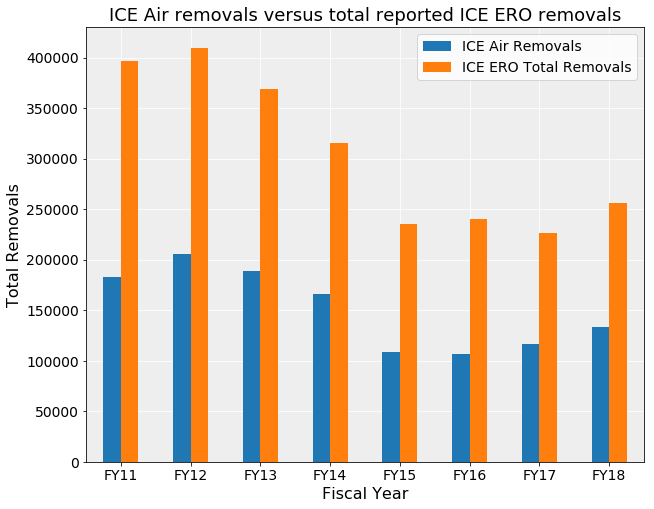

In [125]:
ice_total_bar(ice_total_comparison[['ICE Air Removals', 'ICE ERO Total Removals']],
                     title=f'ICE Air removals versus total reported ICE ERO removals',
                     filename=f'total_removals_comparison',
                     ylabel=f'Total Removals',
                     xlabel='Fiscal Year');

In [128]:
ice_total_comparison['Percent'] = ice_total_comparison['ICE Air Removals'] / ice_total_comparison['ICE ERO Total Removals']

In [130]:
(ice_total_comparison['Percent'] * 100).min()

44.486899336122036

In [131]:
(ice_total_comparison['Percent'] * 100).max()

52.60569153296639